In [52]:
# Import libraries
import pickle
import matplotlib.pyplot as plt
import gensim.matutils
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, Word2Vec
from scipy.sparse import csr_matrix
from gensim.corpora import Dictionary
from nltk.corpus import wordnet

In [53]:
# Define the file path
pickle_file = 'processed_data.pkl'

In [54]:
# Read the processed data from the Pickle file
with open(pickle_file, 'rb') as file:
    processed_data = pickle.load(file)

In [55]:
# Retrieve data
title = processed_data['title']
abstract = processed_data['abstract']

In [56]:
title

0                               [reconstruct, effect, map]
1                  [rotation, invariance, neural, network]
2        [spherical, polyharmonics, poisson, kernels, p...
3        [finite, element, approximation, stochastic, m...
4        [comparative, study, discrete, wavelet, transf...
                               ...                        
20967    [contemporary, machine, learn, guide, practiti...
20968    [uniform, diamond, coat, hard, alloy, cut, ins...
20969         [analyse, soccer, game, cluster, conceptors]
20970    [efficient, simulation, sum, correlate, variates]
20971                 [optional, stop, problem, bayesians]
Name: title, Length: 20972, dtype: object

In [57]:
abstract

0        [predictive, model, allow, inference, analyze,...
1        [rotation, invariance, translation, invariance...
2        [introduce, develop, notion, spherical, polyha...
3        [stochastic, landau, lifshitz, gilbert, llg, e...
4        [ftir, spectra, sample, 7, plant, species, use...
                               ...                        
20967    [machine, learn, find, increasingly, broad, ap...
20968    [polycrystalline, diamond, coat, grow, cement,...
20969    [present, new, approach, identify, situations,...
20970    [sum, variates, encounter, many, challenge, ap...
20971    [recently, optional, stop, subject, debate, ba...
Name: abstract, Length: 20972, dtype: object

In [58]:
# Concatenate titles and abstracts
documents = [" ".join(t) + " " + " ".join(a) for t, a in zip(title, abstract)]

In [59]:
# Define the range of values for max_df and min_df to search over
param_grid = {
    'max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'min_df': [2, 3, 4, 5]
}

In [60]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [61]:
# Perform grid search with specified scoring metric
grid_search = GridSearchCV(estimator=tfidf_vectorizer, param_grid=param_grid, cv=5, scoring='neg_log_loss')
grid_search.fit(documents)

C:\Users\chewr\anaconda3\envs\nlp\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\chewr\anaconda3\envs\nlp\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\chewr\anaconda3\envs\nlp\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=TfidfVectorizer(stop_words='english'),
             param_grid={'max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
                         'min_df': [2, 3, 4, 5]},
             scoring='neg_log_loss')

In [62]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_df': 0.7, 'min_df': 2}


In [63]:
# Get the best estimator
best_estimator = grid_search.best_estimator_

In [64]:
# Transform the documents using the best estimator
tfidf_matrix = best_estimator.transform(documents)

In [65]:
# Convert tfidf_matrix to a corpus for LSA
corpus = gensim.matutils.Sparse2Corpus(tfidf_matrix.T)

In [66]:
# Tokenize documents into lists of words
tokenized_documents = [doc.split() for doc in documents]

In [67]:
# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_documents)

In [68]:
# Set up parameters for LSA
num_topics_range = [5, 10, 15, 20]

In [69]:
# Initialize coherence_scores list
coherence_scores = []


# Calculate coherence score
for num_topics in num_topics_range:
    # Apply Truncated SVD for LSA using the best parameters
    lsa_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    lsa_matrix = lsa_model[corpus]
    
    # Extract list of words for each topic
    topics = [topic[1] for topic in lsa_model.show_topics(num_topics=num_topics)]
    
    # Calculate coherence score
    coherence_model = CoherenceModel(topics=topics, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

In [70]:
print("Coherence Scores:", coherence_scores)

Coherence Scores: [0.6504670033249693, 0.6550008653014522, 0.6641244779001576, 0.6627051728705081]


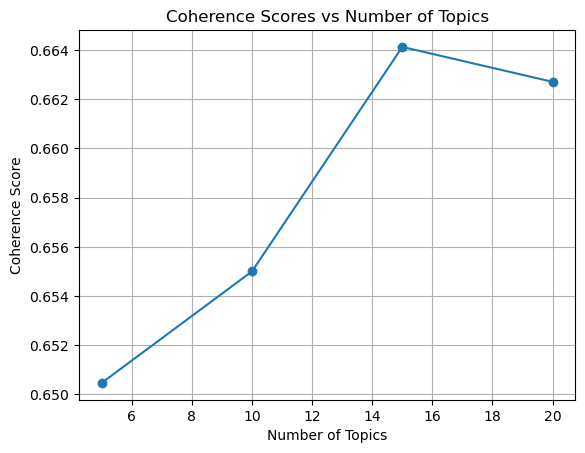

In [71]:
# Plot the coherence scores
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.title('Coherence Scores vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()

In [72]:
# Choose the optimal number of topics based on the highest coherence score
num_topics_optimal = num_topics_range[coherence_scores.index(max(coherence_scores))]
print("Optimal Number of Topics:", num_topics_optimal)

Optimal Number of Topics: 15


In [73]:
# Apply LSA with the Optimal Number of Topics
lsa_model_optimal = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics_optimal)
lsa_matrix_optimal = lsa_model_optimal[corpus]

Topic 0: 0.242*"supersymmetry" + 0.214*"broadcasters" + 0.196*"véronique" + 0.167*"db" + 0.157*"humid" + 0.125*"minibatch" + 0.113*"practical" + 0.112*"inadequacy" + 0.106*"sublattices" + 0.105*"isochrones"


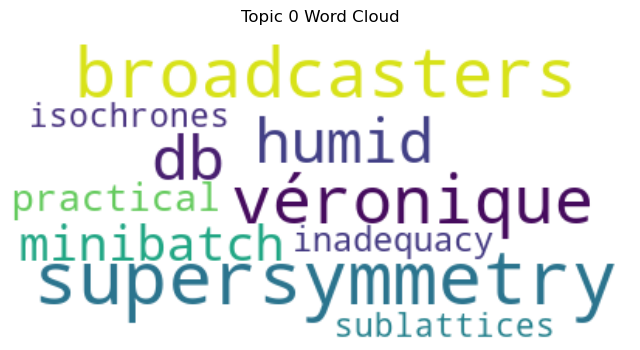

Topic 1: -0.371*"broadcasters" + -0.333*"véronique" + -0.217*"viewers" + -0.197*"acvae" + -0.190*"protosun" + 0.117*"duplication" + 0.117*"lda" + 0.114*"lieu" + -0.114*"flink" + 0.100*"dow"


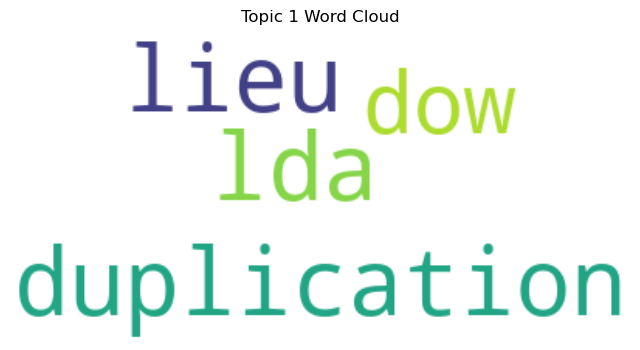

Topic 2: 0.529*"soap" + -0.187*"supersymmetry" + 0.169*"versus" + 0.151*"isochrones" + -0.148*"wavefront" + -0.142*"nika" + -0.130*"sixties" + -0.115*"duplication" + -0.111*"lda" + -0.103*"gier"


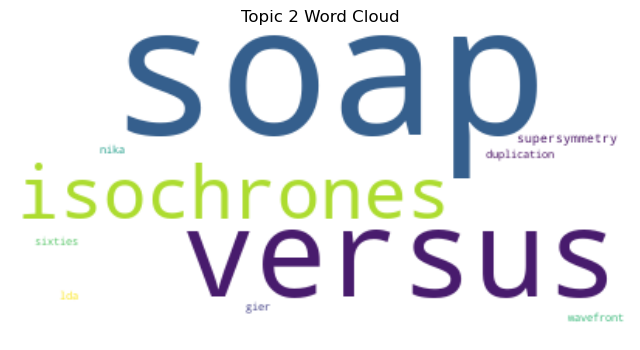

Topic 3: 0.549*"broadcasters" + 0.422*"soap" + -0.183*"db" + 0.160*"viewers" + -0.134*"véronique" + -0.124*"supersymmetry" + 0.117*"lieu" + 0.106*"duplication" + -0.105*"smoteboost" + -0.104*"versus"


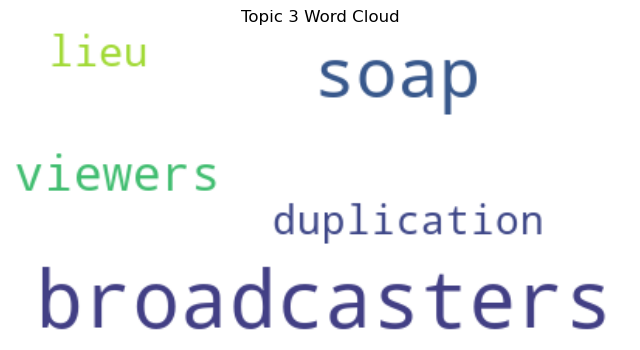

Topic 4: 0.565*"soap" + 0.281*"supersymmetry" + -0.227*"broadcasters" + -0.192*"dow" + 0.186*"db" + -0.156*"lieu" + -0.149*"viewers" + 0.148*"subcode" + -0.129*"bharanedhar" + -0.119*"acvae"


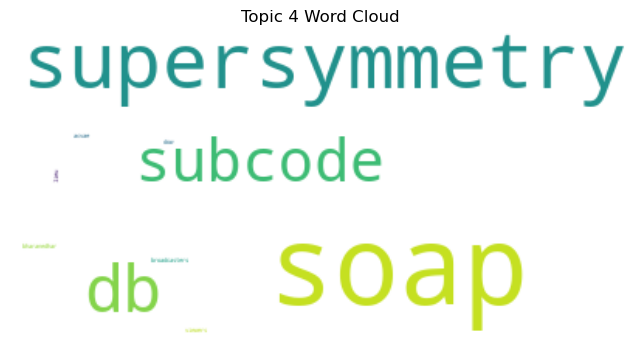

Topic 5: 0.454*"véronique" + -0.444*"broadcasters" + 0.228*"lieu" + 0.166*"soap" + -0.154*"supersymmetry" + 0.154*"fu" + -0.116*"curtailment" + 0.116*"duplication" + 0.115*"flink" + 0.108*"acvae"


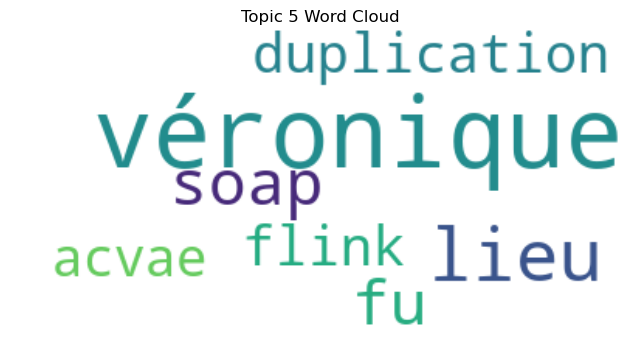

Topic 6: 0.537*"supersymmetry" + 0.295*"lieu" + -0.216*"versus" + -0.145*"backup" + -0.139*"tomographic" + -0.134*"contour" + -0.132*"isochrones" + 0.125*"bharanedhar" + 0.101*"db" + -0.098*"incentivizing"


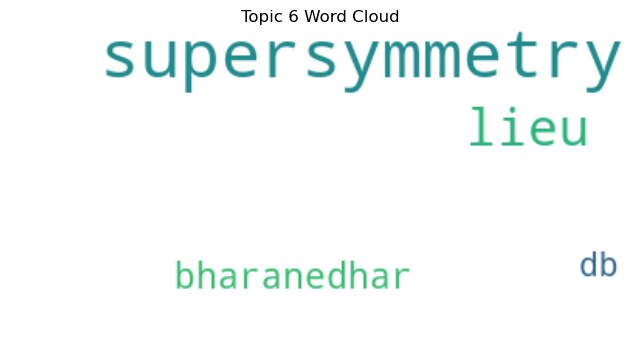

Topic 7: -0.367*"supersymmetry" + -0.304*"véronique" + 0.265*"fu" + 0.234*"lieu" + 0.233*"db" + 0.228*"subcode" + -0.163*"soap" + -0.159*"duplication" + -0.157*"sixties" + 0.114*"tritellurides"


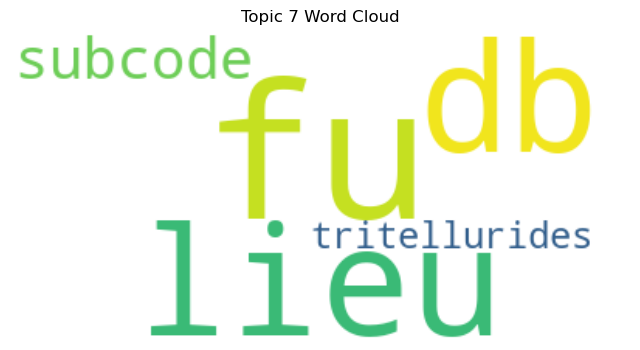

Topic 8: 0.220*"lieu" + -0.215*"dow" + 0.208*"tomographic" + -0.207*"smoteboost" + -0.188*"fu" + 0.184*"aptasensors" + -0.147*"protosun" + 0.144*"supersymmetry" + -0.125*"wavefront" + 0.123*"encapsulations"


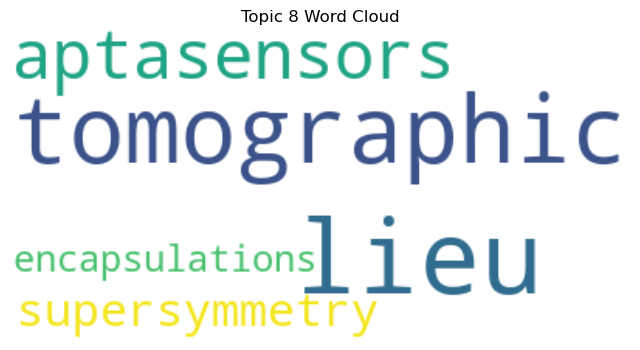

Topic 9: -0.368*"fu" + 0.306*"lieu" + -0.241*"beamformer" + -0.227*"binaurally" + -0.219*"harshaw" + 0.216*"duplication" + 0.163*"subcode" + -0.160*"soap" + 0.134*"versus" + 0.133*"smoteboost"


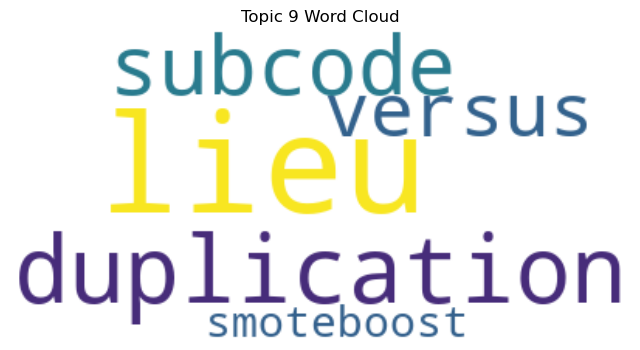

Topic 10: 0.381*"fu" + -0.317*"subcode" + -0.306*"véronique" + 0.241*"duplication" + -0.211*"tritellurides" + -0.153*"approximant" + -0.134*"levitch" + 0.122*"inadequacy" + -0.117*"harshaw" + -0.108*"beamformer"


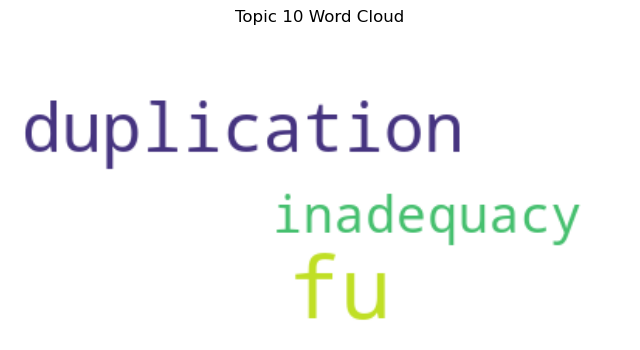

Topic 11: -0.507*"db" + 0.316*"lieu" + 0.274*"supersymmetry" + 0.188*"versus" + 0.183*"fu" + 0.149*"subcode" + 0.133*"tritellurides" + -0.126*"duplication" + 0.125*"backup" + 0.103*"approximant"


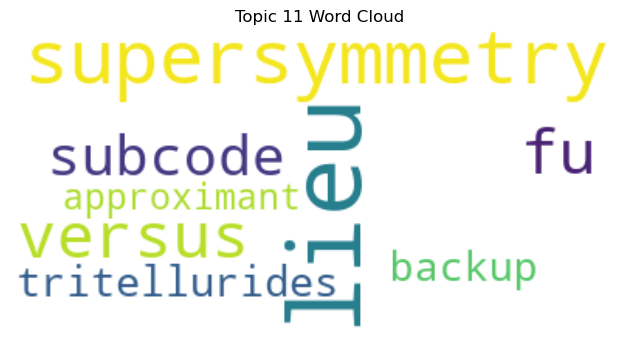

Topic 12: 0.450*"subcode" + -0.261*"dow" + 0.241*"db" + 0.198*"binaurally" + 0.186*"harshaw" + 0.179*"beamformer" + 0.177*"duplication" + 0.172*"versus" + 0.158*"lieu" + 0.136*"inadequacy"


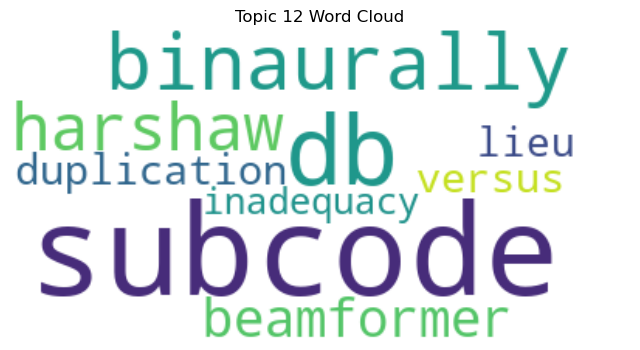

Topic 13: 0.387*"lieu" + -0.300*"duplication" + -0.294*"dow" + -0.293*"subcode" + 0.192*"smoteboost" + -0.184*"supersymmetry" + -0.148*"bharanedhar" + 0.136*"binaurally" + 0.135*"véronique" + -0.121*"encapsulations"


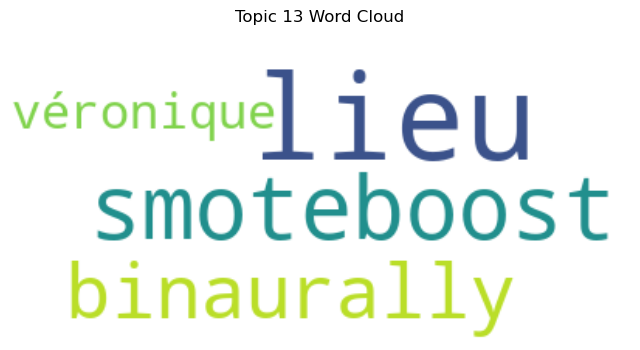

Topic 14: -0.511*"duplication" + 0.240*"wavefront" + -0.161*"smoteboost" + 0.153*"lda" + 0.151*"rcgans" + -0.129*"tomographic" + 0.128*"supersymmetry" + -0.128*"aptasensors" + -0.128*"fu" + 0.126*"backup"


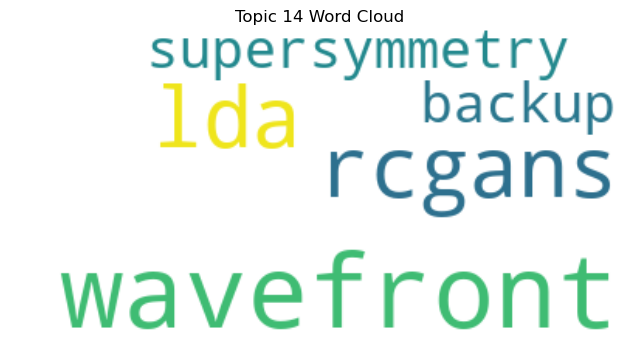

In [74]:
# Visualization of Topics (Word Clouds)
topics = lsa_model_optimal.show_topics(num_topics=num_topics_optimal, num_words=10)

for topic_id, topic in topics:
    print(f"Topic {topic_id}: {topic}")
    
    # Extract words and probabilities from the topic representation string
    word_prob_pairs = [pair.split("*") for pair in topic.split(" + ")]
    words = [pair[1][1:-1] for pair in word_prob_pairs]
    probabilities = [float(pair[0]) for pair in word_prob_pairs]
    word_prob_dict = dict(zip(words, probabilities))
    
    # Generate word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_prob_dict)
    
    # Plot word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_id} Word Cloud')
    plt.axis('off')
    plt.show()


In [75]:
# Examine the Top Words & Interpret the Words
for topic_id, topic in topics:
    print(f"\nTopic {topic_id}:")
    top_words = [pair.split("*") for pair in topic.split(" + ")]
    top_words = [(float(weight), word.strip('"')) for weight, word in top_words]
    top_words.sort(reverse=True)
    print("Top Words:")
    for weight, word in top_words:
        print(f"{word}: {weight}")


Topic 0:
Top Words:
supersymmetry: 0.242
broadcasters: 0.214
véronique: 0.196
db: 0.167
humid: 0.157
minibatch: 0.125
practical: 0.113
inadequacy: 0.112
sublattices: 0.106
isochrones: 0.105

Topic 1:
Top Words:
lda: 0.117
duplication: 0.117
lieu: 0.114
dow: 0.1
flink: -0.114
protosun: -0.19
acvae: -0.197
viewers: -0.217
véronique: -0.333
broadcasters: -0.371

Topic 2:
Top Words:
soap: 0.529
versus: 0.169
isochrones: 0.151
gier: -0.103
lda: -0.111
duplication: -0.115
sixties: -0.13
nika: -0.142
wavefront: -0.148
supersymmetry: -0.187

Topic 3:
Top Words:
broadcasters: 0.549
soap: 0.422
viewers: 0.16
lieu: 0.117
duplication: 0.106
versus: -0.104
smoteboost: -0.105
supersymmetry: -0.124
véronique: -0.134
db: -0.183

Topic 4:
Top Words:
soap: 0.565
supersymmetry: 0.281
db: 0.186
subcode: 0.148
acvae: -0.119
bharanedhar: -0.129
viewers: -0.149
lieu: -0.156
dow: -0.192
broadcasters: -0.227

Topic 5:
Top Words:
véronique: 0.454
lieu: 0.228
soap: 0.166
fu: 0.154
duplication: 0.116
flink: 0.11

In [76]:
# Train Word2Vec model
word2vec_model = Word2Vec(tokenized_documents, vector_size=100, window=5, min_count=1, workers=4)

In [77]:
# Define a function to calculate similarity scores between top words and word embeddings
def calculate_similarity(label, top_words, word_embeddings):
    similarity_scores = []
    for word in top_words:
        if word in word_embeddings.wv:
            similarity_scores.append(word_embeddings.wv.similarity(word, label))
        else:
            similarity_scores.append(0)  # Set similarity score to 0 if word not in vocabulary
    return similarity_scores

In [78]:
# Assign labels to topics based on similarity scores
topic_labels = {}
for topic_id, topic in topics:
    top_words = [pair.split("*")[1].strip().strip('"') for pair in topic.split(" + ")]
    similarity_scores = calculate_similarity(topic_id, top_words, word2vec_model)
    max_score_index = similarity_scores.index(max(similarity_scores))
    topic_labels[topic_id] = top_words[max_score_index]

In [79]:
# Print topic labels
print("Topic Labels:")
for topic_id, label in topic_labels.items():
    print(f"Topic {topic_id}: {label}")

Topic Labels:
Topic 0: isochrones
Topic 1: acvae
Topic 2: lda
Topic 3: duplication
Topic 4: acvae
Topic 5: acvae
Topic 6: incentivizing
Topic 7: subcode
Topic 8: wavefront
Topic 9: harshaw
Topic 10: duplication
Topic 11: approximant
Topic 12: subcode
Topic 13: binaurally
Topic 14: lda


In [80]:
import pickle

# Define the filename for saving the model
filename = 'lsa_word2vec_model.pkl'

# Create a dictionary to store all necessary components of model
lsa_model_data = {
    'lsa_model_optimal': lsa_model_optimal,
    'dictionary': dictionary,
    'word2vec_model': word2vec_model,
    'topic_labels': topic_labels
}

# Save the model to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(lsa_model_data, file)

print("Model saved successfully!")


Model saved successfully!


In [81]:
import pickle

# Assuming you have already created the dictionary object
# dictionary = corpora.Dictionary(tokenized_documents)

# Define the filename for saving the dictionary
filename = 'lsa_dictionary.pkl'

# Save the dictionary to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(dictionary, file)

print("Dictionary saved successfully!")

Dictionary saved successfully!


In [82]:
# Define the filename for saving the LsiModel
filename = 'lsa_model_optimal.pkl'

# Save the LsiModel to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(lsa_model_optimal, file)

print("LsiModel saved successfully!")

LsiModel saved successfully!
